In [2]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import model.profile_performance as profile_performance
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.special
import sklearn
import matplotlib.pyplot as plt

### Define paths for the model and data of interest

In [18]:
# Define the paths to the peak BEDs and profile BigWigs
base_path = "/users/amtseng/tfmodisco/data/interim/ENCODE/"

peaks_bed = os.path.join(base_path, "SPI1/SPI1_ENCSR000BGQ_GM12878_train_peakints.bed.gz")

prof_bigwigs = [
    (os.path.join(base_path, e_1), os.path.join(base_path, e_2)) \
    for e_1, e_2 in [
        ("SPI1/SPI1_ENCSR000BGQ_GM12878_neg.bw",
        "SPI1/SPI1_ENCSR000BGQ_GM12878_pos.bw"),
        ("SPI1/SPI1_ENCSR000BGW_K562_neg.bw",
        "SPI1/SPI1_ENCSR000BGW_K562_pos.bw"),
        ("SPI1/SPI1_ENCSR000BIJ_GM12891_neg.bw",
        "SPI1/SPI1_ENCSR000BIJ_GM12891_pos.bw"),
        ("SPI1/SPI1_ENCSR000BUW_HL-60_neg.bw",
        "SPI1/SPI1_ENCSR000BUW_HL-60_pos.bw"),
        ("SPI1/control_ENCSR000BGG_K562_neg.bw",
        "SPI1/control_ENCSR000BGG_K562_pos.bw"),
        ("SPI1/control_ENCSR000BGH_GM12878_neg.bw",
        "SPI1/control_ENCSR000BGH_GM12878_pos.bw"),
        ("SPI1/control_ENCSR000BIH_GM12891_neg.bw",
        "SPI1/control_ENCSR000BIH_GM12891_pos.bw"),
        ("SPI1/control_ENCSR000BVU_HL-60_neg.bw",
        "SPI1/control_ENCSR000BVU_HL-60_pos.bw")
    ]
]

num_tasks = int(len(prof_bigwigs) / 2)
# Path to saved model
model_path = "/users/amtseng/tfmodisco/models/trained_models/SPI1/20/model_ckpt_epoch_1.h5"

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [4]:
# Define some constants
# reference_fasta = "/users/amtseng/tfmodisco/data/interim/BPNet/mm10.fasta"
# chrom_sizes = "/users/amtseng/tfmodisco/data/interim/BPNet/mm10.canon.chrom.sizes"
# input_length = 1000
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

In [5]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles, in order of BigWigs given in `prof_bigwigs`
coords_to_vals_list = [
    (
        make_profile_dataset.CoordsToVals(path_1, profile_length),
        make_profile_dataset.CoordsToVals(path_2, profile_length)
    )
    for path_1, path_2 in prof_bigwigs
]
def coords_to_profs(coords):
    return np.stack([
        np.stack([ctv_1(coords), ctv_2(coords)], axis=2)
        for ctv_1, ctv_2 in coords_to_vals_list
    ], axis=1)
# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_profs(coords)
    return input_seq, profs

In [6]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting and plotting profiles

In [19]:
# Import the model
custom_objects = {
    "tf": tf,
    "profile_loss": train_profile_model.get_profile_loss_function(num_tasks, profile_length),
    "count_loss": train_profile_model.get_count_loss_function(num_tasks)
}
model = keras.models.load_model(model_path, custom_objects=custom_objects)

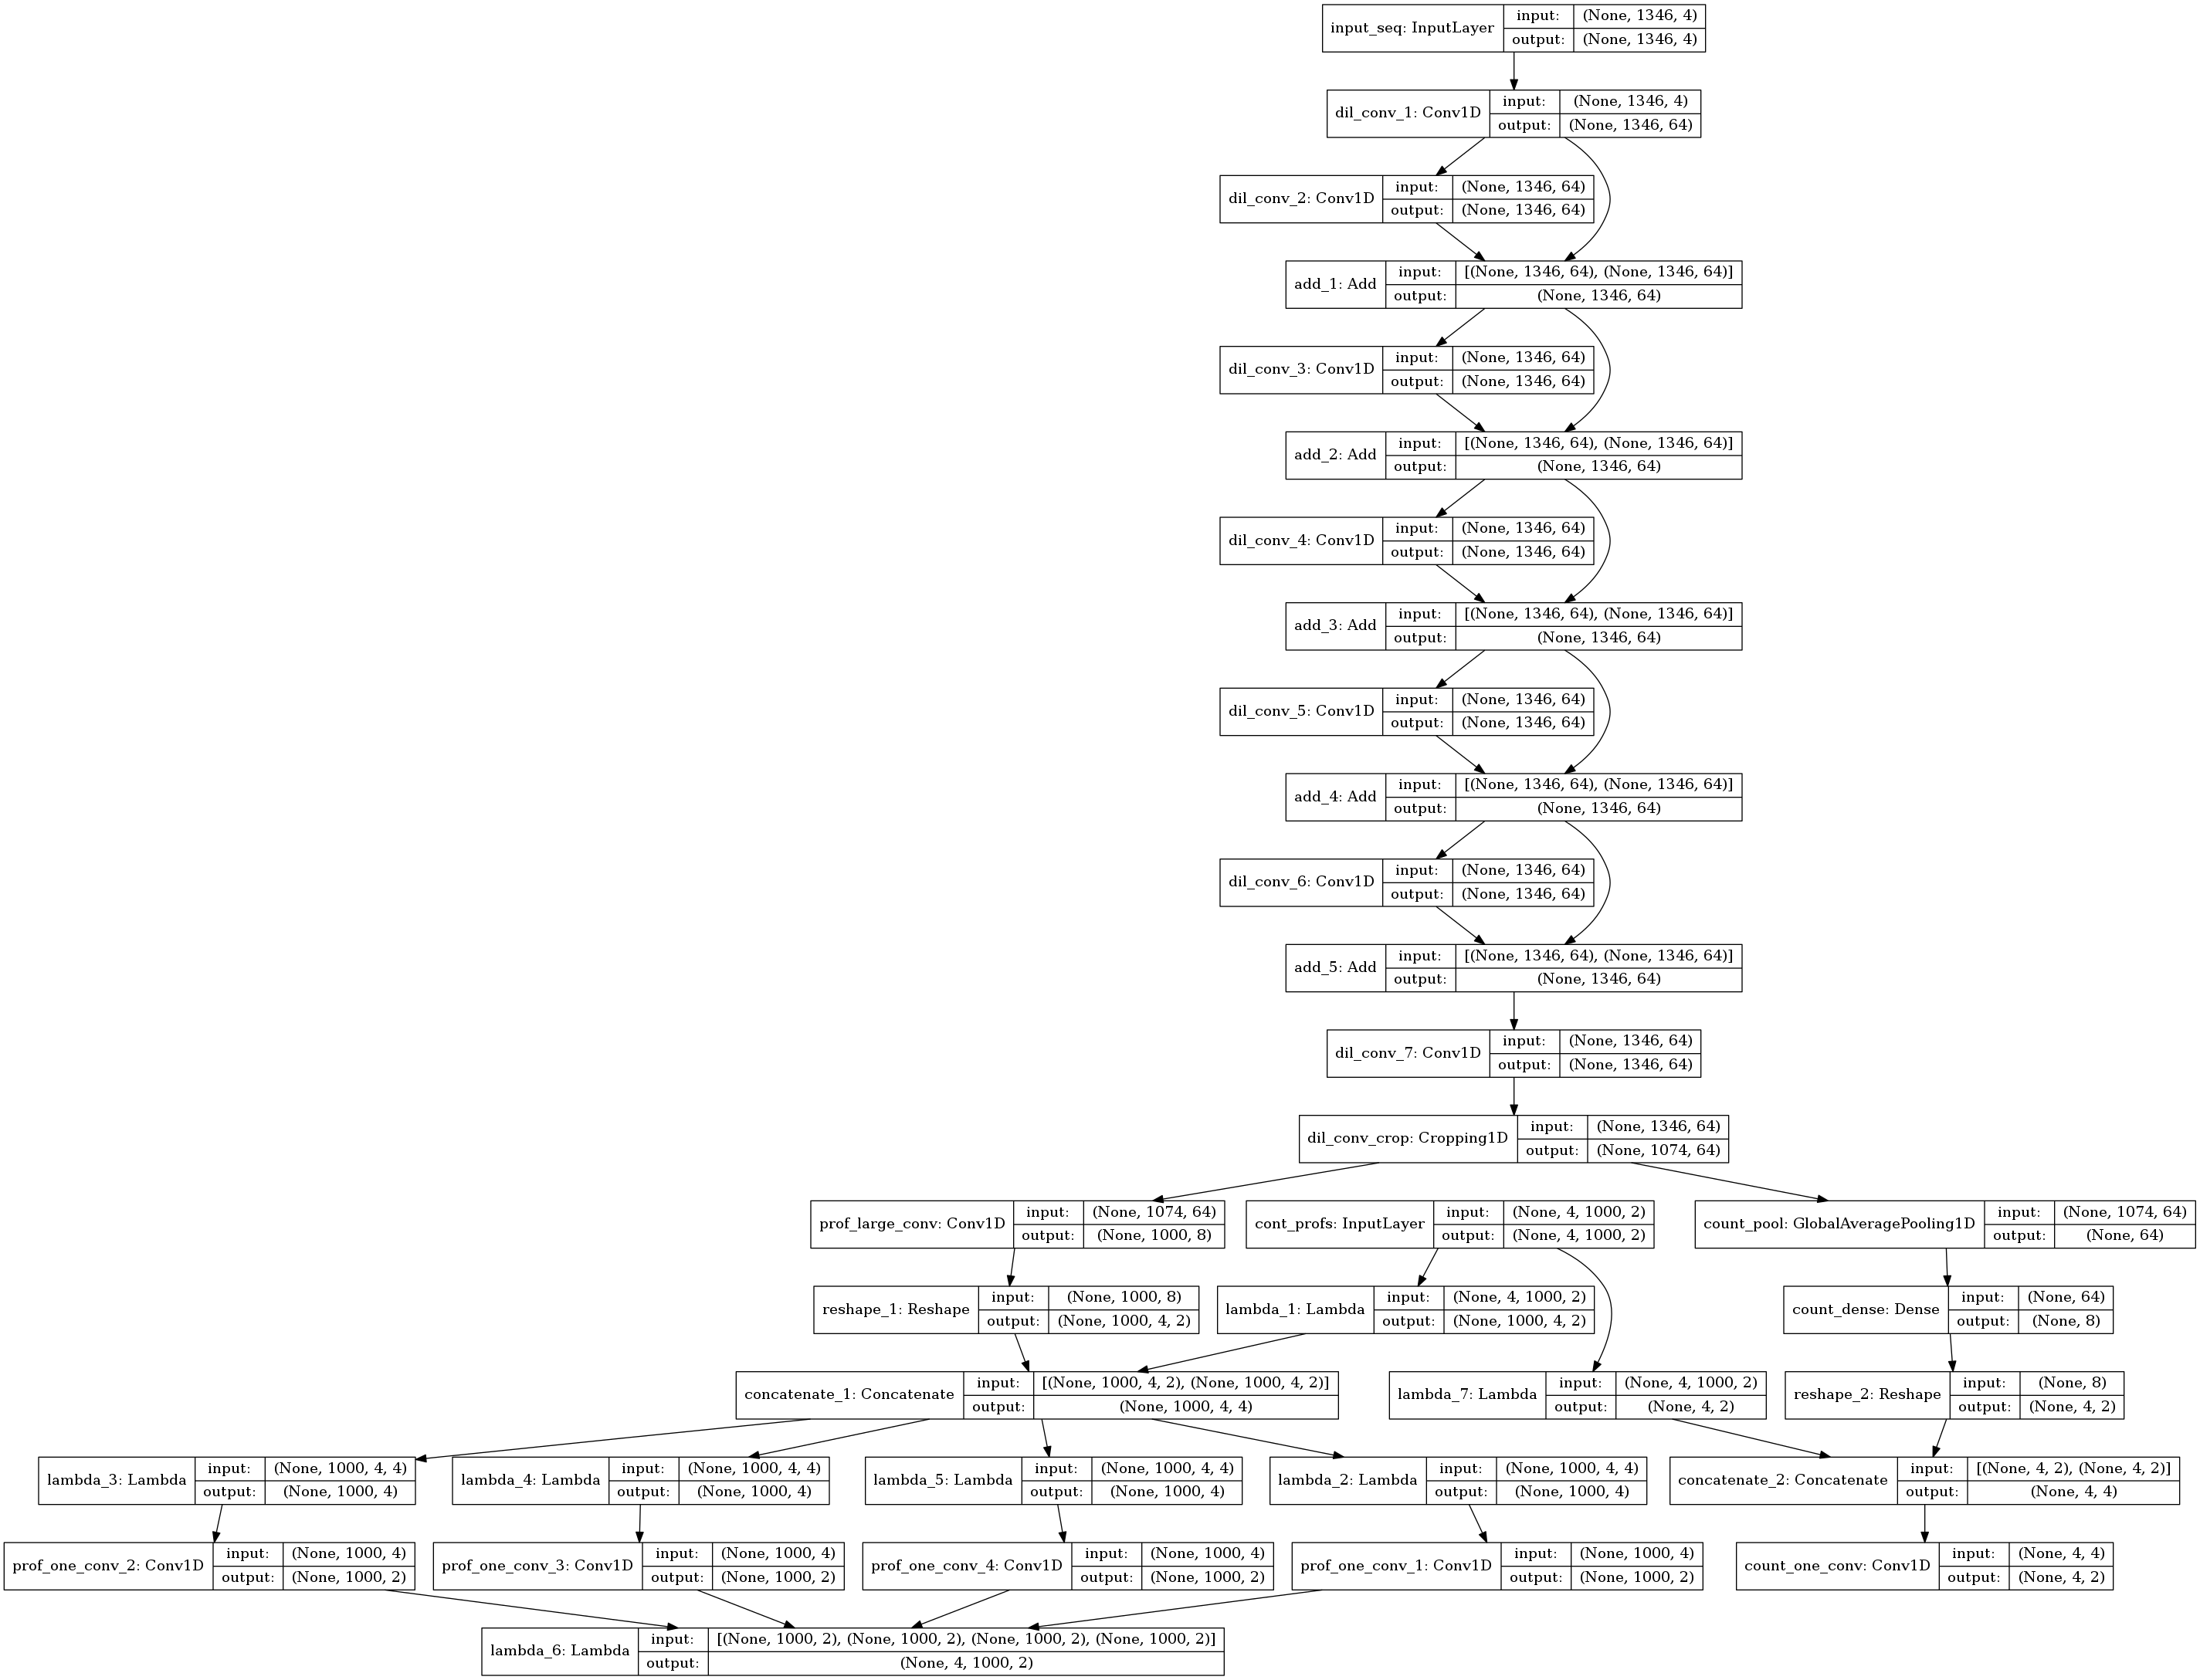

In [20]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')


In [14]:
def predict_coords(coords):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions AND the true values from the dataset.
    The returned predicted profiles are in terms of log probabilities, and the
    returned predicted counts are also log. Returned values are all NumPy arrays.
    """
    input_seq, profiles = coords_to_network_inputs(coords)
    
    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]
    true_counts = np.sum(true_profs, axis=2)

    # Run through the model
    logit_pred_profs, log_pred_counts = model.predict([input_seq, cont_profs])
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(
        logit_pred_profs
    )
    
    return log_pred_profs, log_pred_counts, true_profs, true_counts

In [15]:
def plot_profiles(pred_profs, true_profs, normalize=True, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    pred_profs, true_profs = np.squeeze(pred_profs), np.squeeze(true_profs)
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    if normalize:
        pred_profs = pred_profs / np.expand_dims(np.sum(pred_profs, axis=1), axis=1)
        true_profs = true_profs / np.expand_dims(np.sum(true_profs, axis=1), axis=1)
    fig, ax = plt.subplots(num_tasks, figsize=(15, 20))
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)

### View predictions

In [ ]:
# Sample some positive coordinates
pos_coords_table.sample(10)

In [ ]:
# Sample some negative coordinates
neg_coord_sampler.sample_intervals(10)

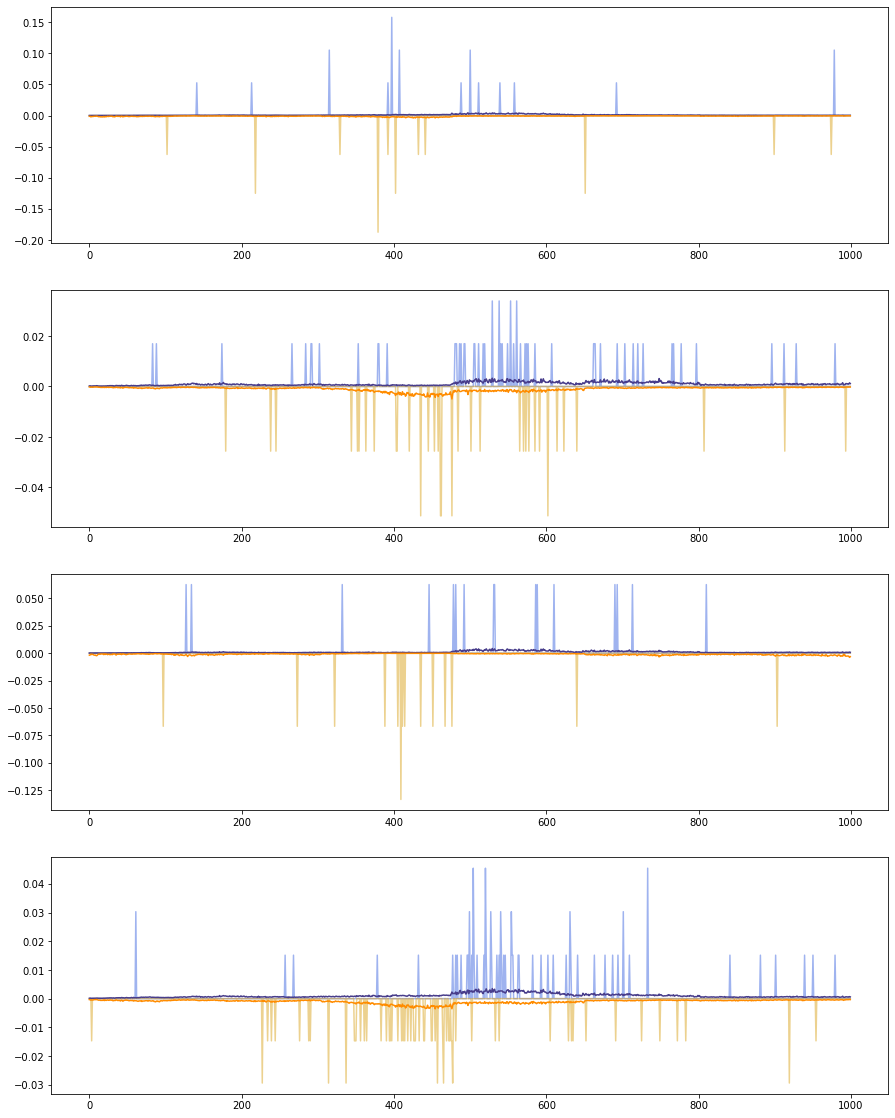

In [22]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr3", 138875547, 138876547)])
pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
plot_profiles(pred_prof_probs, true_prof_probs, normalize=False)

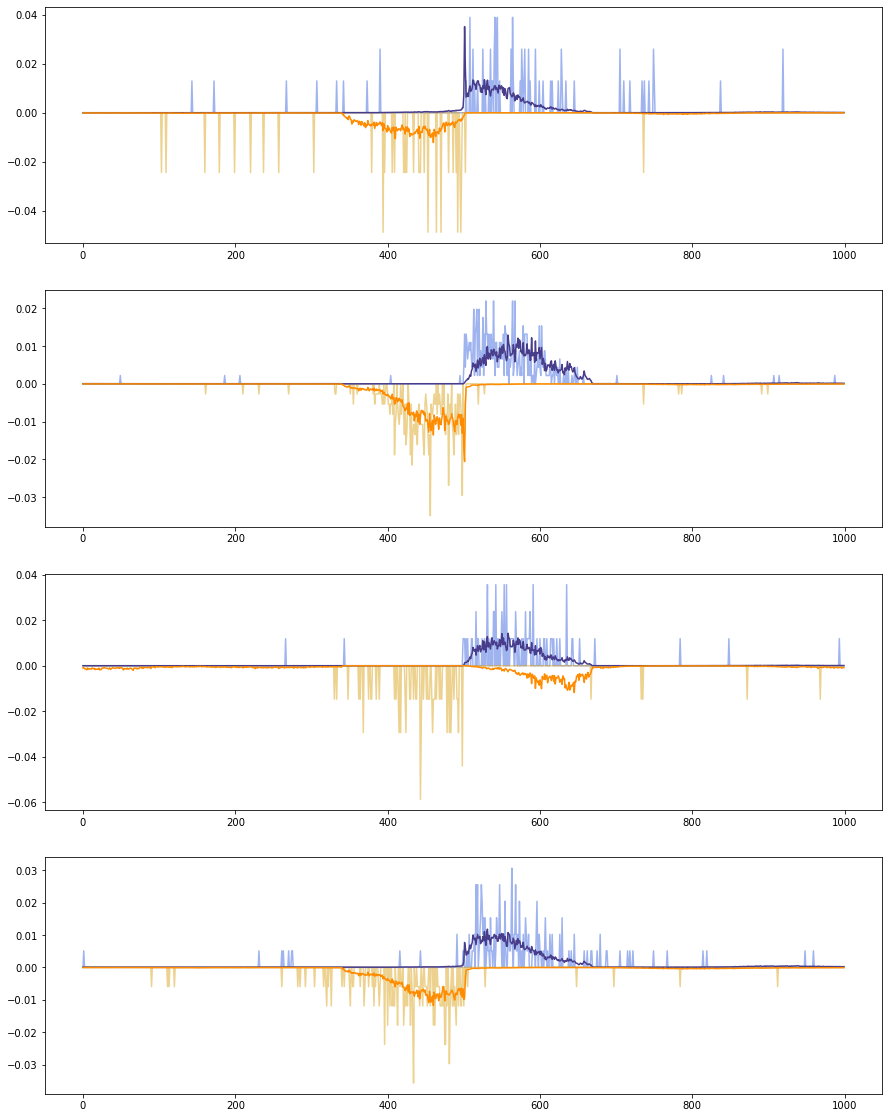

In [21]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr3", 130377839, 130378839)])
pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
plot_profiles(pred_prof_probs, true_prof_probs, normalize=False)

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


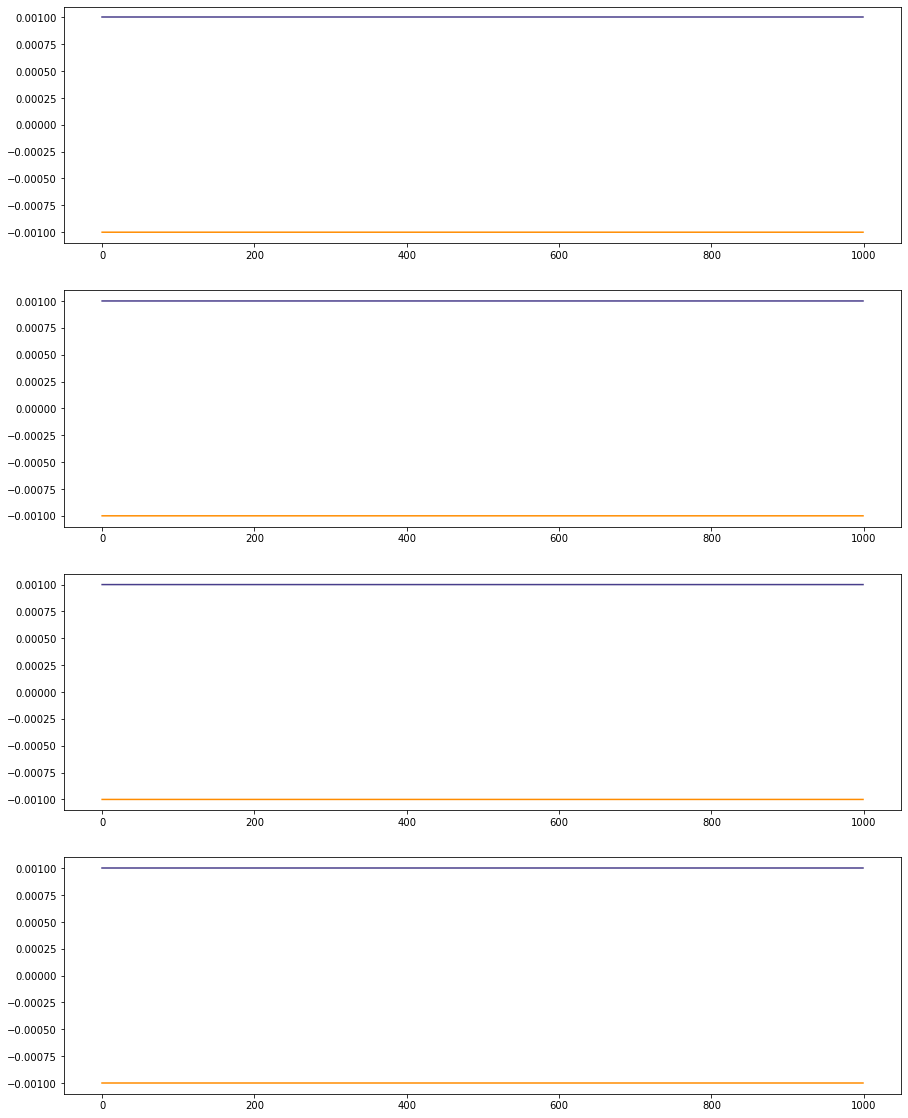

In [25]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr1", 1000, 2000)])
pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
plot_profiles(pred_prof_probs, true_prof_probs, normalize=False)